In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import ast, os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import model_from_yaml
import matplotlib.colors as mcolors
plt.rcParams["figure.figsize"] = (10,10)
numero = 1
path = '../Salida/Flujo{num}/AMB/'.format(num = numero)

In [7]:
import keras
print(keras.__version__)

2.4.3


In [2]:
def enumerate_dimensions(dimension, list_dimensions): 
    return list_dimensions.index(dimension)
def wordsToNumbers(tokens, vocabulary):
    number_array = []
    for i in tokens:
        number_array.append(vocabulary.index(i)+1)
    return np.asarray(number_array)

df = pd.read_csv('../../Data/Flujo{num}.csv'.format(num=numero), sep=";")
df['Respuesta'] = df['Respuesta'].apply(ast.literal_eval)

#Generamos un vocabulario de palabras
vocabulary = []
df['Respuesta'].apply(vocabulary.append)
vocabulary = [item for sublist in vocabulary for item in sublist]
vocabulary.append('')
vocabulary = list(sorted(set(vocabulary)))
vocab_len= len(vocabulary)+1

# Se Construye Dataframe solo de medio ambiente
df = df[df.Area == 'Gobierno Corporativo']
# Lista de dimensiones se pasa a numeros
list_dimensions = df.Dimension.unique().tolist()
num_classes = len(list_dimensions)
df['_dimension'] = df['Dimension'].apply(enumerate_dimensions, list_dimensions = list_dimensions)
df['NumRespuesta'] = df.Respuesta.apply (wordsToNumbers, vocabulary = vocabulary)

# Rellenamos las matrices con 0 para que todas tengan el mismo tamaño
X_completo = pad_sequences(df.NumRespuesta, maxlen=10, dtype='object', padding='post', value = 0)
y_completo = np.array(df['_dimension'])

print('Media', np.array(df.groupby('_dimension').count().NumRespuesta).mean())
print('STD', np.std(df.groupby('_dimension').count().NumRespuesta))
print('Cant. datos', np.sum(df.groupby('_dimension').count().NumRespuesta))
print('Cant. datos min ', np.min(df.groupby('_dimension').count().NumRespuesta))
print('Cant. datos max ', np.max(df.groupby('_dimension').count().NumRespuesta))

Media 7095.0
STD 91.0
Cant. datos 14190
Cant. datos min  7004
Cant. datos max  7186


# Busqueda de Hyperparametros

def gen_train_model(tensor_X, tensor_y, tensor_test_x, tensor_test_y, paramsEmbedding, paramsLSTM, num_clases, optimizer, batch_size, epoch):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim = paramsEmbedding['input_dim'],  output_dim = paramsEmbedding['output_dim'], input_shape=(tensor_X.shape[1],)))
    model.add(tf.keras.layers.LSTM(units = paramsLSTM['units'],
                                   activation = paramsLSTM['activation'],
                                   dropout = paramsLSTM['dropout'],
                                   recurrent_dropout = paramsLSTM['recurrent_dropout']))
    
    model.add(tf.keras.layers.Dense(units = num_clases ,activation='softmax'))
    
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    
    history = model.fit(tensor_X,
                        tensor_y,
                        epochs = epoch,
                        batch_size = batch_size,
                        verbose = 0
                       )
    test_loss, test_acurracy = model.evaluate(tensor_test_x,
                                              tensor_test_y,
                                              verbose=0
                                             )
    
    predictions = model.predict_classes(tensor_test_x)
    medidas = precision_recall_fscore_support(tensor_test_y, predictions )
    print(medidas[0])
    return [test_acurracy, test_loss, medidas, paramsEmbedding, paramsLSTM, optimizer, batch_size, epoch]


def grid_lstm(data_x, data_y, input_dim, output_dim_embe, units_lstm, activ_lstm, drop_lstm, rec_drop_lstm, num_clases, optimizers, batch_size_, epochs):
    X, test_x, y, test_y = train_test_split(data_x, data_y, test_size = 0.1, random_state = 0)
    tensor_X      = tf.convert_to_tensor(list(X))
    tensor_test_x = tf.convert_to_tensor(list(test_x))
    tensor_y      = tf.convert_to_tensor(list(y))
    tensor_test_y = tf.convert_to_tensor(list(test_y))
    resultados = []
    for output_dim in output_dim_embe:
        for units in units_lstm:
            for activ in activ_lstm:
                for drop in drop_lstm:
                    for rec_drop in rec_drop_lstm:
                        for optimizer in optimizers:
                            for batch_size in batch_size_:
                                for epoch in epochs:
                                    resultados.append( gen_train_model(tensor_X, tensor_y, tensor_test_x, tensor_test_y,  
                                                                       {'output_dim':output_dim}, 
                                                                       {'units':units,'activation':activ,'dropout':drop, 'recurrent_dropout':rec_drop},
                                                                       {'optimizador': optimizer, 'batch_size': batch_size, 'epoch': epoch}
                                                                      )
                                                     )
    return resultados

output = grid_lstm(data_x = X_completo,
          data_y = y_completo,
          input_dim = len(vocabulary)+1,
          num_clases = len(list_dimensions),
          output_dim_embe = [60],
          units_lstm = [90, 130],
          activ_lstm = ['tanh', 'sigmoid', 'relu','softmax'],
          drop_lstm = [0.3,0.5,0.7],
          rec_drop_lstm = [0.3,0.5,0.7],
          optimizers = ['rmsprop','adam'],
          batch_size_ = [20, 40],
          epochs = [6,8]
         )

# K-means con parametros encontrados

In [6]:
from keras.utils.vis_utils import plot_model

epoch = 6
batch_size = 40
optimizer = 'rmsprop'
recurrent_dropout = 0.5
dropout = 0.7
activation_lstm = 'relu'
lstm_units = 90
ouput_dim_embedding = 60

kf = KFold(n_splits = 10, shuffle = True, random_state = 2)
resultados = []
contador = 1
for valores_entrenamiento, valores_testeo in kf.split(X_completo):
    tensor_X      = tf.convert_to_tensor(list(X_completo[valores_entrenamiento]))
    tensor_test_x = tf.convert_to_tensor(list(X_completo[valores_testeo]))
    tensor_y      = tf.convert_to_tensor(list(y_completo[valores_entrenamiento]))
    tensor_test_y = tf.convert_to_tensor(list(y_completo[valores_testeo]))
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim = vocab_len, 
                                        output_dim = ouput_dim_embedding,
                                        input_shape=(X_completo.shape[1],)))
    model.add(tf.keras.layers.LSTM(units=lstm_units,
                                   activation=activation_lstm,
                                   dropout = dropout,
                                   recurrent_dropout = recurrent_dropout))
    model.add(tf.keras.layers.Dense(units=num_classes,
                                    activation='sigmoid'))
    print(model.summary())
    
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    
    model.compile(optimizer = optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    history = model.fit(tensor_X,
                        tensor_y,
                        epochs = epoch,
                        batch_size = batch_size,
                        verbose=0)
    test_loss, test_acurracy = model.evaluate(tensor_test_x,
                                              tensor_test_y,
                                              verbose=0
                                             )
    predictions = model.predict_classes(tensor_test_x)
    medidas = precision_recall_fscore_support(tensor_test_y, predictions)
    resultados.append([test_loss, test_acurracy, medidas])
    break
#model.save('../Modelos/Flujo2/model_gob.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 10, 60)            2074500   
_________________________________________________________________
lstm_2 (LSTM)                (None, 90)                54360     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 182       
Total params: 2,129,042
Trainable params: 2,129,042
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
print("loss mean",np.array([res[0] for res in resultados]).mean())
print("acurracy mean",np.array([res[1] for res in resultados]).mean())
print("media precision",np.array([np.array([res[2][0][i] for res in resultados]).mean() for i in range(num_classes)]).mean())
print("media recall",np.array([np.array([res[2][1][i] for res in resultados]).mean() for i in range(num_classes)]).mean())
print("media fscore",np.array([np.array([res[2][2][i] for res in resultados]).mean() for i in range(num_classes)]).mean())
print("media support",np.array([np.array([res[2][3][i] for res in resultados]).mean() for i in range(num_classes)]).mean())

loss mean 0.4719934523105621
acurracy mean 0.785764628648758
media precision 0.7880482844744214
media recall 0.7852601941672266
media fscore 0.784913291445861
media support 709.5


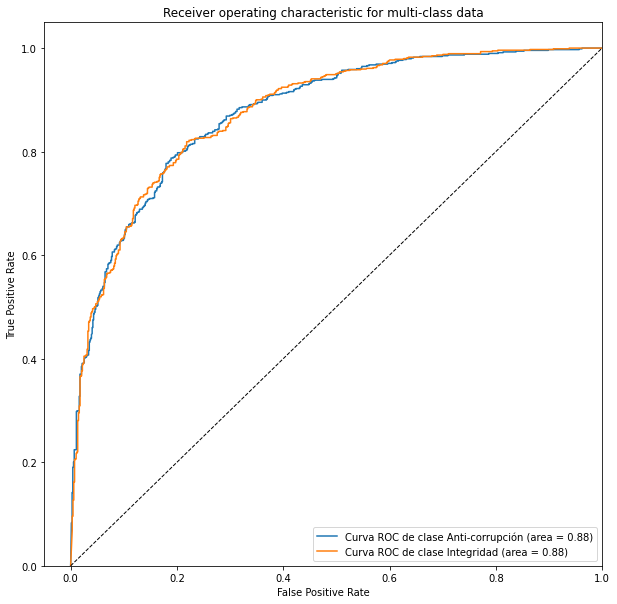

In [12]:
plt.clf() 
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.colors as mcolors
plt.rcParams["figure.figsize"] = (10,10)

y_test_bin = label_binarize(tensor_test_y, classes=range(num_classes))
y_test_bin = np.array([(np.array([0, i[0]]) if 1 in i else np.array([1, i[0]])) for i in y_test_bin])
y_predic_bin = model.predict(tensor_test_x)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_predic_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
dict_colors = list(mcolors.TABLEAU_COLORS.keys()) + ['#000000','#800000', '#FF00FF','#000080', '#00FFFF']
colors = cycle(dict_colors)
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='Curva ROC de clase {0} (area = {1:0.2f})'
             ''.format(list_dimensions[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.savefig(path+"ROC.png")